### Credit Card Default Feedforward Network pipeline example

In [1]:
#import packages
from pyspark.context import SparkContext
# from pyspark.sql.session import SparkSession
#import pyspark packages
## Create SparkContext, SparkSession
import pyspark
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
# Configure MLflow Experiment
mlflow_experiment_id = 866112

# Including MLflow
import mlflow
import mlflow.spark
import os
print("MLflow Version: %s" % mlflow.__version__)

MLflow Version: 1.10.0


In [2]:
#import packages
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *


from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g"))
init_engine()

/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [3]:
#Setting the path for Spark
os.environ['JAVA_HOME']="/usr/lib/jvm/java-8-oracle"
os.environ['SPARK_HOME'] = "/home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/kunal/Downloads/jarfiles/bigdl-SPARK_2.2-0.7.0-jar-with-dependencies.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.3 pyspark-shell'

In [4]:
# # spark = SparkSession(sc)
# #Create configuration and sessions
# # conf = SparkConf().setAppName("Python_Spark_PHD_Complete").setMaster('local')
# sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]"))
# # sc = SparkContext(conf=conf)
# spark = SparkSession(sc)

In [5]:
#Creating Spark Session
from pyspark.context import SparkContext
# from pyspark.sql.session import SparkSession
#import pyspark packages
## Create SparkContext, SparkSession
import pyspark
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.sql import SQLContext
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [6]:
#Define Parameters
learning_rate = 0.1
training_epochs = 20
batch_size = 1024
display_step = 1

# Network Parameters
n_input = 5
n_classes = 2
n_hidden_1 = 3 # 1st layer number of features
n_hidden_2 = 2 # 1st layer number of features

In [7]:
#Read file
filename =  "./data/default-simple.csv"
LABELS = ["Good", "Default"] 

In [8]:
# Number of hidden layers
n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))

Hidden layer 1 (Guess) : 2.5900200641113513
Hidden layer 2 (Guess) : 2.23606797749979


In [9]:
#Define Schema 
schema = StructType() \
              .add("id",IntegerType(),True) \
              .add("balance",IntegerType(),True) \
              .add("sex",IntegerType(),True) \
              .add("education",IntegerType(),True) \
              .add("marriage",IntegerType(),True) \
              .add("age",IntegerType(),True) \
              .add("default",IntegerType(),True)

In [11]:
# import pandas as pd
df=pd.read_csv("./data/default-simple.csv")

In [12]:
df.head()

,id,balance,sex,education,marriage,age,default
0,1,20000,2,2,1,24,2
1,2,120000,2,2,2,26,2
2,3,90000,2,2,2,34,1
3,4,50000,2,2,1,37,1
4,5,50000,1,2,1,57,1


In [14]:
#Method to convert from pandas dataframe to Spark data frame
# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)
# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
          struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

In [15]:
cc_training=pandas_to_spark(df)

In [16]:
cc_training.show()

+---+-------+---+---------+--------+---+-------+
| id|balance|sex|education|marriage|age|default|
+---+-------+---+---------+--------+---+-------+
|  1|  20000|  2|        2|       1| 24|      2|
|  2| 120000|  2|        2|       2| 26|      2|
|  3|  90000|  2|        2|       2| 34|      1|
|  4|  50000|  2|        2|       1| 37|      1|
|  5|  50000|  1|        2|       1| 57|      1|
|  6|  50000|  1|        1|       2| 37|      1|
|  7| 500000|  1|        1|       2| 29|      1|
|  8| 100000|  2|        2|       2| 23|      1|
|  9| 140000|  2|        3|       1| 28|      1|
| 10|  20000|  1|        3|       2| 35|      1|
| 11| 200000|  2|        3|       2| 34|      1|
| 12| 260000|  2|        1|       2| 51|      1|
| 13| 630000|  2|        2|       2| 41|      1|
| 14|  70000|  1|        2|       2| 30|      2|
| 15| 250000|  1|        1|       2| 29|      1|
| 16|  50000|  2|        3|       3| 23|      1|
| 17|  20000|  1|        1|       2| 24|      2|
| 18| 320000|  1|   

In [17]:
cc_training.printSchema()

root
 |-- id: long (nullable = true)
 |-- balance: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- education: long (nullable = true)
 |-- marriage: long (nullable = true)
 |-- age: long (nullable = true)
 |-- default: long (nullable = true)



In [20]:
cc_training.printSchema()

root
 |-- id: long (nullable = true)
 |-- balance: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- education: long (nullable = true)
 |-- marriage: long (nullable = true)
 |-- age: long (nullable = true)
 |-- default: long (nullable = true)
 |-- label: double (nullable = true)



In [21]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, column
for col_name in cc_training.columns:
    cc_training = cc_training.withColumn(col_name, col(col_name).cast('integer'))

In [22]:
cc_training = cc_training.withColumn('label', cc_training.default.cast("double"))

In [23]:
cc_training.printSchema()

root
 |-- id: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- marriage: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- default: integer (nullable = true)
 |-- label: double (nullable = true)



In [24]:
cc_training.select('balance','sex','education','marriage','age','default').describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|           balance|               sex|         education|          marriage|              age|          default|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|  count|             30000|             30000|             30000|             30000|            30000|            30000|
|   mean|167484.32266666667|1.6037333333333332|1.8531333333333333|1.5518666666666667|          35.4855|           1.2212|
| stddev|129747.66156720239|0.4891291960902604|0.7903486597207298|0.5219696006132487|9.217904068090194|0.415061805690933|
|    min|             10000|                 1|                 0|                 0|               21|                1|
|    max|           1000000|                 2|                 6|                 3|               79|                2|
+-------+---------------

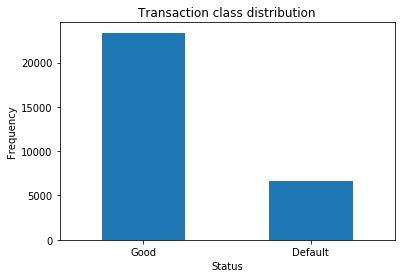

In [25]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('default').toPandas()['default'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Status")
plt.ylabel("Frequency");

In [26]:
#Split data into training and validation set
(trainingData, validData) = cc_training.select('balance','sex','education','marriage','age','label').randomSplit([.8,.2])

In [27]:
#Creating pipeline
assembler =  VectorAssembler(inputCols=['balance','sex','education','marriage','age'], outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(trainingData)
cc_data_training = pipelineTraining.transform(trainingData)
pipelineTest = pipeline.fit(validData)
cc_data_test = pipelineTest.transform(validData)

In [29]:
help(cc_data_training)

Help on DataFrame in module pyspark.sql.dataframe object:

class DataFrame(builtins.object)
 |  A distributed collection of data grouped into named columns.
 |  
 |  A :class:`DataFrame` is equivalent to a relational table in Spark SQL,
 |  and can be created using various functions in :class:`SparkSession`::
 |  
 |      people = spark.read.parquet("...")
 |  
 |  Once created, it can be manipulated using the various domain-specific-language
 |  (DSL) functions defined in: :class:`DataFrame`, :class:`Column`.
 |  
 |  To select a column from the data frame, use the apply method::
 |  
 |      ageCol = people.age
 |  
 |  A more concrete example::
 |  
 |      # To create DataFrame using SparkSession
 |      people = spark.read.parquet("...")
 |      department = spark.read.parquet("...")
 |  
 |      people.filter(people.age > 30).join(department, people.deptId == department.id) \
 |        .groupBy(department.name, "gender").agg({"salary": "avg", "age": "max"})
 |  
 |  .. versionadd

In [28]:
#Top 20 rows
cc_data_training.show()

+-------+---+---------+--------+---+-----+--------------------+--------------------+
|balance|sex|education|marriage|age|label|           assembled|            features|
+-------+---+---------+--------+---+-----+--------------------+--------------------+
|  10000|  1|        1|       1| 41|  1.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 22|  2.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 22|  2.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 23|  1.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 23|  2.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 24|  2.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 24|  2.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 29|  1.0|[10000.0,1.0,1.0,...|[0.07704545366067...|
|  10000|  1|        1|       2| 30|  1.0|[10000.0,1.0,1.0,...|[0

In [30]:
#Create BigDL Model
bigDLModel = Sequential().add(Linear(n_input, n_hidden_1)).add(Linear(n_hidden_1, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(training_epochs).setBatchSize(batch_size)

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier


DLClassifier_7a1c9a347dd9

In [31]:
#Training
model = dlClassifier.fit(cc_data_training)
print("\ninitial model training finished.")


initial model training finished.


In [32]:
# from pyspark.sql import DataFrame, SQLContext
# predictionDF = DataFrame(model.transform(cc_data_test), SQLContext(sc))
# predictionDF

In [33]:
#columns
cc_data_test.columns

['balance',
 'sex',
 'education',
 'marriage',
 'age',
 'label',
 'assembled',
 'features']

In [38]:
#select some columns
predictionDF=model.transform(cc_data_test)

In [39]:
#top 20 rows
predictionDF.show()

+-------+---+---------+--------+---+-----+--------------------+--------------------+----------+
|balance|sex|education|marriage|age|label|           assembled|            features|prediction|
+-------+---+---------+--------+---+-----+--------------------+--------------------+----------+
|  10000|  1|        1|       1| 38|  2.0|[10000.0,1.0,1.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        1|       2| 24|  2.0|[10000.0,1.0,1.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        2|       2| 21|  2.0|[10000.0,1.0,2.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        2|       2| 22|  1.0|[10000.0,1.0,2.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        2|       2| 22|  2.0|[10000.0,1.0,2.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        2|       2| 23|  2.0|[10000.0,1.0,2.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        2|       2| 24|  1.0|[10000.0,1.0,2.0,...|[0.07718600707791...|       1.0|
|  10000|  1|        2|       2| 24|  2.

In [40]:
#Model Evolution
predictionDF.cache()
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + str(auPRC))
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + str(recall))

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + str(precision))
predictionDF.unpersist()


Area under precision-recall curve: = 1.0

recall = 0.7753492193919475

Precision = 0.6011664120117023


DataFrame[balance: int, sex: int, education: int, marriage: int, age: int, label: double, assembled: vector, features: vector, prediction: double]

In [41]:
#Another Evolution
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

The prediction accuracy is 77.53%


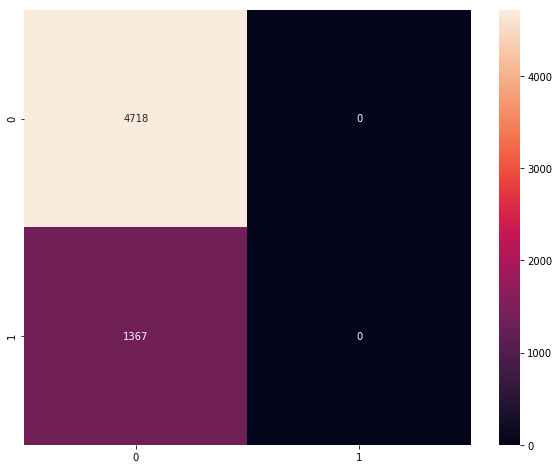

In [42]:
#prediction accuracy
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');